In [229]:
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
from pathlib import Path
import random
import plotly.express as px
from scipy import ndimage
import math
from tqdm.auto import tqdm
import pandas as pd
from skimage.filters import difference_of_gaussians

In [2]:
import sys
sys.path.append('../../30_data_tools/')

from helper import load_dotenv

In [3]:
dotenv = load_dotenv()

In [4]:
tile_dataset = Path('../Model/dataset/train')

In [5]:
moire_images = list( (tile_dataset / 'moire').glob('./*.jpg') )

In [77]:
def get_fft( input_img ):
    ft = np.fft.ifftshift(np.array(input_img)[:,:,0])
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    return ft

def invert_fft (input_real, input_imaginary):
    input = (input_real + 1j * input_imaginary)
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

In [7]:
def get_spherical_coordinate( x, y ):
    r = math.sqrt( x ** 2 + y ** 2 )
    angle = math.degrees(math.atan2(y,x))

    return r, angle

In [8]:
def get_carthesian_coordinate( r, angle ):
    x = r * math.cos(math.radians(angle))
    y = r * math.sin(math.radians(angle))
    return x, y

In [9]:
def limit_frequencies( fft, inner_limit=None, outer_limit=None ):
    center = (fft.shape[1] / 2, fft.shape[0] / 2)
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r = math.sqrt( abs(center[0] - x) ** 2 + abs(center[1] - y) ** 2 )
            
            if outer_limit is not None and r > outer_limit:
                fft[y,x] = 0
    
            if inner_limit is not None and r < inner_limit:
                fft[y,x] = 0

    return fft

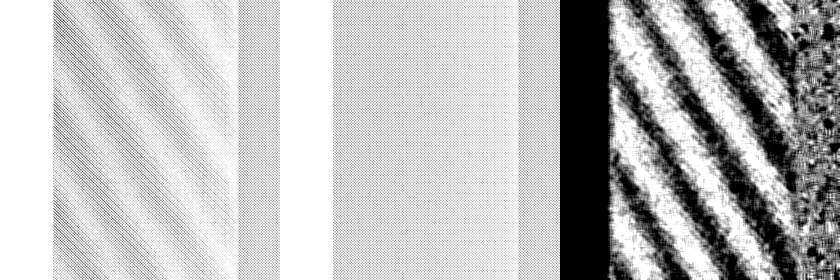

In [280]:
moire_path = random.choices(moire_images, k=1)[0]
non_moire_path = tile_dataset / 'no_moire' / moire_path.name

moire_img = Image.open( moire_path )
no_moire_img = Image.open( non_moire_path )

diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))
diff_img = diff_img.filter(ImageFilter.BoxBlur(2))
enhancer = ImageEnhance.Contrast(diff_img)
diff_img = enhancer.enhance(2)


fft = get_fft(diff_img)
fft = limit_frequencies( fft, inner_limit=10, outer_limit=140 )

display_image = Image.new(size=(moire_img.size[0]*3, moire_img.size[1]), mode='L')
display_image.paste(moire_img, (0,0))
display_image.paste(no_moire_img, (moire_img.size[0],0))
display_image.paste(diff_img, (moire_img.size[0]*2,0))

display_image

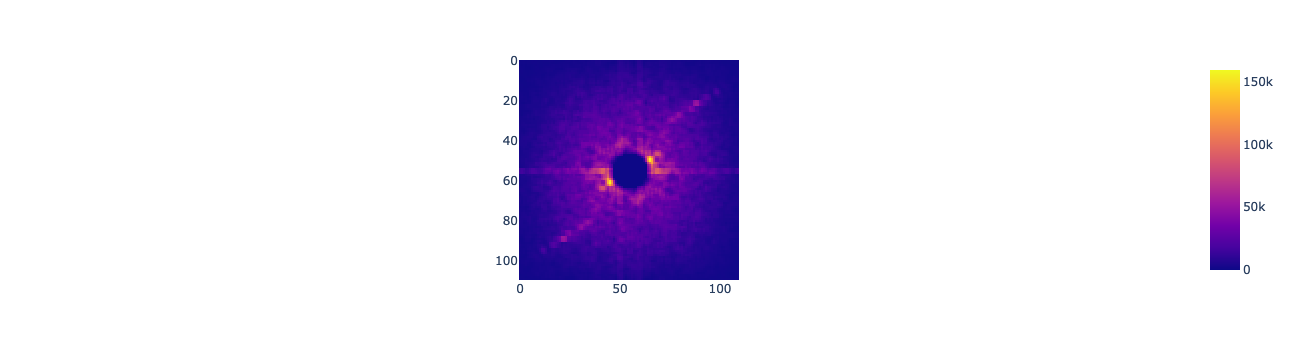

In [281]:
filtered = ndimage.uniform_filter( np.abs(fft) , size=3)[85:195,85:195]
#filtered = filtered ** 2
#filtered[filtered < filtered.max() * 0.6] = 0
#filtered = ndimage.uniform_filter( np.abs(filtered) , size=5)

px.imshow( filtered )

In [233]:
def get_radiant_map( frequency_img ):
    out_map = np.zeros((
        round(math.sqrt((frequency_img.shape[1] / 2) ** 2 + (frequency_img.shape[0] / 2) ** 2)) + 1, # max. Radius (45°)
        360 # 360°
    ))
    
    for y_raw in range(frequency_img.shape[0]):
        for x_raw in range(frequency_img.shape[1]):
            x = x_raw - frequency_img.shape[1] / 2
            y = y_raw - frequency_img.shape[0] / 2
    
            r, angle = get_spherical_coordinate( x, y )
            
            out_map[
                round(r),
                round(angle) + 180 - 1
            ] += frequency_img[y_raw,x_raw]

    return out_map

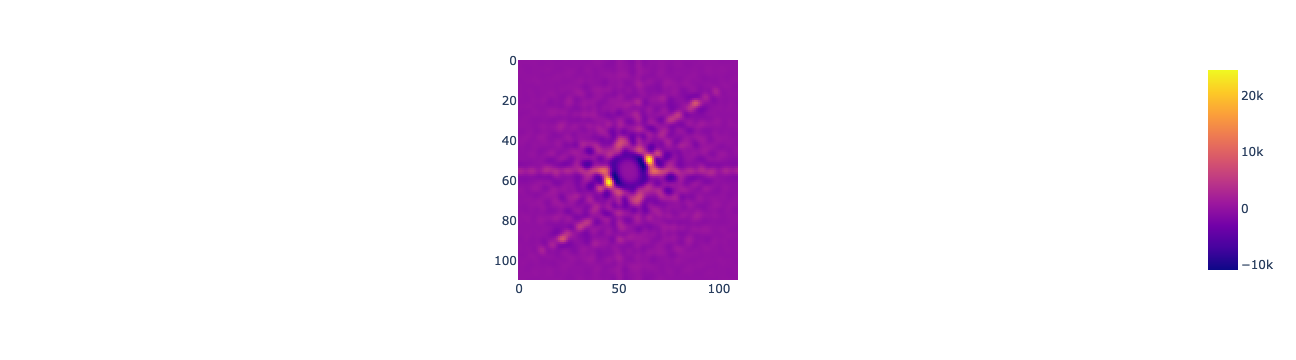

In [282]:
px.imshow(
    difference_of_gaussians( filtered, 1.5 )
)

In [340]:
def get_main_impulses( input, relevant_level=0.66 ):
    y_positions, x_positions = np.where(input >= input.max() * relevant_level)
    main_impulses = []

    for i in range(y_positions.shape[0]):
            x = x_positions[i] - input.shape[1] / 2
            y = y_positions[i] - input.shape[0] / 2
            
            r, angle = get_spherical_coordinate(x,y)
            #angle += 90 # Anpassung um 0° in der vertikalen, nicht der horizontalen zu haben
            intensity = input[y_positions[i],x_positions[i]]
        
            main_impulses.append((r, angle, intensity))

    return main_impulses

In [382]:
# anzahl der Hauptimpulse
# Clusteranalyse
def get_clusters_of_impulses( impulses, max_distance=5 ):
    clusters = []
    sorted_impulses = [False for imp in impulses]
    
    def sort_impulse( imp_index ):
        imp = impulses[imp_index]
        connected_impulses = [imp]
        sorted_impulses[imp_index] = True
    
        for i in range(len(impulses)):
            if sorted_impulses[i] == False:
                imp2 = impulses[i]
                distance = math.sqrt(
                    abs(imp[0] - imp2[0]) ** 2 +
                    abs(imp[1] - imp2[1]) ** 2
                )
    
                if distance <= max_distance:
                    connected_impulses += sort_impulse( i )
    
        return connected_impulses
    
    
    while False in sorted_impulses:
        clusters.append( sort_impulse(sorted_impulses.index(False)) )

    return clusters

In [377]:
def get_processed_diff_img( moire_path ):
    non_moire_path = tile_dataset / 'no_moire' / moire_path.name

    moire_img = Image.open( moire_path )
    no_moire_img = Image.open( non_moire_path )
    
    diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))
    diff_img = diff_img.filter(ImageFilter.BoxBlur(2))
    enhancer = ImageEnhance.Contrast(diff_img)
    diff_img = enhancer.enhance(2)

    return diff_img

In [373]:
def normalize_impulses( impulses ):
    normalized_impulses = {}
    
    for r, angle, intensity in impulses:
        r = round(r)
        angle = round(angle)
    
        if angle >= 0 and angle < 180:
            key = (r,angle)
    
            if key not in normalized_impulses:
                normalized_impulses[key] = []
    
            normalized_impulses[key].append(intensity)
    
    return [
        (key[0], key[1], sum(normalized_impulses[key]) / len(normalized_impulses[key]))
        for key in normalized_impulses
    ]

# Impulse herausschnippeln

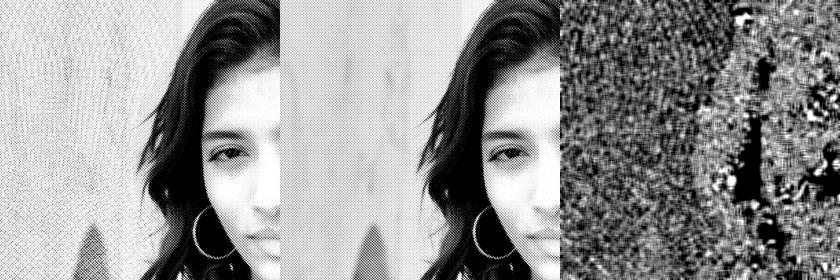

In [339]:
display_image = Image.new(size=(moire_img.size[0]*3, moire_img.size[1]), mode='L')
display_image.paste(moire_img, (0,0))
display_image.paste(no_moire_img, (moire_img.size[0],0))
display_image.paste(diff_img, (moire_img.size[0]*2,0))

display_image

In [375]:
def get_impulse_rows_of_tile( moire_path ):
    diff_img = get_processed_diff_img( moire_path )
    
    fft = get_fft(diff_img)
    fft = limit_frequencies( fft, inner_limit=10, outer_limit=140 )
    filtered = ndimage.uniform_filter( np.abs(fft) , size=3)[85:195,85:195]
    dog_fft = difference_of_gaussians( filtered, 1.5 )
    
    # impulse normalisieren
    all_impulses = get_main_impulses( dog_fft )
    normalized_impulses = normalize_impulses( all_impulses )
    clusters = get_clusters_of_impulses( normalized_impulses )
    
    rows = []
    for i in range(len(clusters)):
        c = clusters[i]
        radius = np.array([imp[0] for imp in c])
        degrees = np.array([imp[1] for imp in c])
        impulses = np.array([imp[2] for imp in c])
        
        rows.append({
            'img_name' : moire_path.name,
            'impulse_idx' : i,
            'radius_mean' : radius.mean(),
            'radius_std' : radius.std(),
            'radius_min' : radius.min(),
            'radius_max' : radius.max(),
            'radius_span' : radius.max() - radius.min(),
            'degree_mean' : degrees.mean(),
            'degree_std' : degrees.std(),
            'degree_min' : degrees.min(),
            'degree_max' : degrees.max(),
            'degree_span' : degrees.max() - degrees.min(),
            'impulse_mean' : impulses.mean(),
            'impulse_std' : impulses.std(),
            'impulse_min' : impulses.min(),
            'impulse_max' : impulses.max(),
            'impulse_span' : impulses.max() - impulses.min(),
        })

    return rows

In [389]:
rows = []

for moire_path in tqdm(moire_images):
    rows += get_impulse_rows_of_tile( moire_path )

  0%|          | 0/2427 [00:00<?, ?it/s]

In [390]:
df = pd.DataFrame.from_dict(rows)

In [396]:
df.groupby('img_name').count().impulse_idx.describe()

count    2427.000000
mean        2.263700
std         1.541302
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        11.000000
Name: impulse_idx, dtype: float64

In [391]:
df.describe()

,impulse_idx,radius_mean,radius_std,radius_min,radius_max,radius_span,degree_mean,degree_std,degree_min,degree_max,degree_span,impulse_mean,impulse_std,impulse_min,impulse_max,impulse_span
count,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000,5494.000000
mean,1.156352,14.814689,0.693593,13.881871,15.817073,1.935202,92.431908,2.700296,88.571533,96.421005,7.849472,18380.424488,1788.156054,16041.490460,21188.041751,5146.551291
std,1.438128,7.136921,0.451861,7.111634,7.221284,1.461499,60.482188,2.157465,60.675200,60.131553,7.093874,16800.597297,2319.814452,13983.927802,20246.157507,6755.634442
min,0.000000,10.285714,0.000000,9.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4158.846483,0.000000,3972.363817,4255.555029,0.000000
25%,0.000000,11.500000,0.500000,11.000000,12.000000,1.000000,40.609091,0.942809,35.000000,45.000000,2.000000,9337.316308,403.139747,8386.177663,10454.546037,973.660587
50%,1.000000,12.000000,0.728431,11.000000,13.000000,2.000000,90.500000,2.500000,85.000000,95.000000,6.000000,13651.711100,1142.581796,12173.767444,15350.355195,3287.104552
75%,2.000000,13.125000,0.856957,12.000000,15.000000,3.000000,145.650000,3.779645,142.000000,151.000000,11.000000,19709.793647,2206.701033,17323.505686,22815.869239,6431.491925
max,10.000000,51.000000,7.182033,51.000000,52.000000,21.000000,178.000000,22.712758,178.000000,178.000000,74.000000,150134.505392,21699.795500,122596.103268,185236.093984,62639.990716


In [ ]:
import cv2
from sklearn.cluster import KMeans

In [ ]:
X = []

for moire_path in tqdm(selected_moires):
    non_moire_path = tile_dataset / 'no_moire' / moire_path.name
    
    moire_img = Image.open( moire_path )
    no_moire_img = Image.open( non_moire_path )
    
    diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))
    diff_img = diff_img.filter(ImageFilter.BoxBlur(2))
    enhancer = ImageEnhance.Contrast(diff_img)
    diff_img = enhancer.enhance(2)
    
    fft = get_fft(diff_img.filter(ImageFilter.BoxBlur(2)))
    fft = limit_frequencies( fft, inner_limit=10, outer_limit=130 )

    filtered = ndimage.uniform_filter( np.abs(fft) , size=5)[85:195,85:195]
    #filtered = filtered ** 2
    filtered[filtered < filtered.max() * 0.6] = 0
    filtered = ndimage.uniform_filter( np.abs(filtered) , size=5)
                
    resized = cv2.resize(
        filtered,
        (50,50)
    )
    resized /= resized.max()

    X.append(resized)

In [ ]:
X_train = np.array([entry.reshape((50*50,)) for entry in X])

In [ ]:
def display_image_grid( images, img_size=(280,280) ):
    cols = 5
    rows = math.ceil( len(images) / cols )
    
    display_image = Image.new(
        size=(img_size[0]*cols,img_size[1]*rows),
        mode='RGB'
    )
    
    for i in range(len(images)):
        row = math.floor(i / cols)
        col = i % cols

        display_image.paste(
            Image.open(images[i]),
            (col*img_size[0],row*img_size[1])
        )

    return display_image

# Silhouette Analysis

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
for n_clusters in range(2,10):

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X_train)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(X_train)

In [ ]:
display_image_grid( [selected_moires[i] for i in range(len(selected_moires)) if kmeans.labels_[i] == 2][:50] )

In [ ]:
moire_path = random.choice(moire_images)
non_moire_path = tile_dataset / 'no_moire' / moire_path.name

moire_img = Image.open( moire_path )
no_moire_img = Image.open( non_moire_path )

diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))

fft = get_fft(diff_img.filter(ImageFilter.BoxBlur(2)))
fft = limit_frequencies( fft, inner_limit=10, outer_limit=130 )

r, angle = get_main_impulse( fft )
angle = angle + 90
T = 1 / r * 280

print(T, angle)

px.imshow(ndimage.uniform_filter( np.abs(fft) , size=5))

In [ ]:
coors = [
    (155,117),
    (123,145),
    (137,155),
    (129,123),
    (147,113),
    (142,120),
    (128,128),
    (129,145),
    (154,150),
    (150,143),
    (117,138)
]

In [ ]:
for co in coors:
    print( get_spherical_coordinate(140 - co[0],140 - co[1]) )

In [ ]:
moire_img

In [ ]:
moire_path

In [ ]:
diff_img.save('/Users/frederic.birwe/Downloads/test.jpg')